# Import modules

In [1]:
import stlab
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
from scipy.optimize import *
import time
import sys 
import io
import os
from IPython.display import display, Javascript
from shutil import *
from stlab.devices.RS_SGS100A import RS_SGS100A

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from Configuration_BMDevice import config, RR_1_IF,RO_lo, readout_len, Q1_lo, Q1_IF, sat_Q1_len, gauss_len, R1_RS, Q1_RS
print(readout_len)

152


# Edit configuration parameters

**To do**

# Define microwave sources

In [2]:
RR = RS_SGS100A("TCPIP::169.254.2.20::INSTR", reset=True,verb=True) 
RR.EXTref()
RR.RFon()
RR.setCWpower(-15)
RR.setCWfrequency(RO_lo)
RR.write(':SOURce:IQ:IMPairment:LEAKage:I ' + R1_RS[0])
RR.write('SOURce:IQ:IMPairment:LEAKage:Q ' + R1_RS[1])
RR.write(':SOURce:IQ:IMPairment:IQRatio:MAGNitude ' + R1_RS[2])
RR.write(':SOURce:IQ:IMPairment:QUADrature:ANGLe ' + R1_RS[3])
RR.IQon()
RR.write(':SOURce:IQ:IMPairment:STATe ON')

QDrive = RS_SGS100A("TCPIP::169.254.50.124::INSTR", reset=True,verb=True) 
QDrive.EXTref()
QDrive.RFon()
QDrive.setCWpower(-35)
QDrive.setCWfrequency(Q1_lo)
QDrive.write(':SOURce:IQ:IMPairment:LEAKage:I ' + Q1_RS[0])
QDrive.write('SOURce:IQ:IMPairment:LEAKage:Q ' + Q1_RS[1])
QDrive.write(':SOURce:IQ:IMPairment:IQRatio:MAGNitude ' + Q1_RS[2])
QDrive.write(':SOURce:IQ:IMPairment:QUADrature:ANGLe ' + Q1_RS[3])
QDrive.IQon()
QDrive.write(':SOURce:IQ:IMPairment:STATe ON')

Global NI ResourceManager created
*RST
SOUR:ROSC:SOUR EXT
OUTP ON
SOUR:POW:POW -1.50000000e+01
FREQ:CW 4240000000
:SOURce:IQ:IMPairment:LEAKage:I 0.73
SOURce:IQ:IMPairment:LEAKage:Q -0.83
:SOURce:IQ:IMPairment:IQRatio:MAGNitude 0.009
:SOURce:IQ:IMPairment:QUADrature:ANGLe -1.65
IQ:STATe ON
:SOURce:IQ:IMPairment:STATe ON
*RST

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\highlevel.py:2823: FutureWarning: @ni backend name is deprecated and will be removed in 1.12. Use @ivi instead. Check the documentation for details
  warnings.warn(



SOUR:ROSC:SOUR EXT
OUTP ON
SOUR:POW:POW -3.50000000e+01
FREQ:CW 5847550000
:SOURce:IQ:IMPairment:LEAKage:I -2.10
SOURce:IQ:IMPairment:LEAKage:Q -0.05
:SOURce:IQ:IMPairment:IQRatio:MAGNitude 0.012
:SOURce:IQ:IMPairment:QUADrature:ANGLe 0.13
IQ:STATe ON
:SOURce:IQ:IMPairment:STATe ON


# Configure QM unit

In [3]:
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

2021-11-25 14:34:19,381 - qm - INFO - Performing health check
2021-11-25 14:34:19,386 - qm - INFO - Health check passed


# QUA Program

In [4]:
def Detuning_Power_Rabi(n_max, f_vec, a_vec, b, t, QLO_Power):
    QDrive.setCWpower(QLO_Power)
    
    f_min = np.min(f_vec)
    f_max = np.max(f_vec)
    df = f_vec[1]-f_vec[0]
    
    a_min = np.min(a_vec)
    a_max = np.max(a_vec)
    
    if len(a_vec) == 1: 
        da = 1 
    else:
        da = a_vec[1]-a_vec[0]
    
    with program() as detuning_power_Rabi:  
        ##############################
        # declare real-time variables:
        ##############################

        n = declare(int)        # Averaging
        f = declare(int)        # Frequencies
        a = declare(fixed)

        A=declare(fixed)
        B=declare(fixed)
        iA=declare(fixed)
        iB=declare(fixed)
        Re=declare(fixed)
        Im=declare(fixed)

        Re_st = declare_stream()
        Im_st = declare_stream()

        ###############
        # the sequence:
        ###############
        with for_(n, 0, n < n_max, n + 1):

            with for_(f, f_min, f < f_max + df/2, f + df):
                
                update_frequency("Q1", f)
                
                with for_(a,a_min,a<a_max+da/2,a+da):

                    wait(int(2500/4),"RR_1","Q1")

                    play("gaussian"*amp(a), "Q1", duration = t)
                    align("Q1", "RR_1")
                    measure("readout"*amp(b), "RR_1", None, demod.full("integW_cos", A, "out1"),
                                                                demod.full("integW_sin",B,"out2"),
                                                                demod.full("integW_sin", iA, "out1"),
                                                                demod.full("integW_cos",iB,"out2"))

                    assign(Re, A + B)       
                    assign(Im, iA - iB)
                    save(Re, Re_st)
                    save(Im, Im_st)              

        with stream_processing():
            Re_st.buffer(len(f_vec), len(a_vec)).average().save("Re")
            Im_st.buffer(len(f_vec), len(a_vec)).average().save("Im")

    job = qm.execute(detuning_power_Rabi, duration_limit=0, data_limit=0)

    res_handles= job.result_handles
    res_handles.wait_for_all_values()

    Re_handle = res_handles.get("Re")
    Im_handle = res_handles.get("Im")

    Re_s = Re_handle.fetch_all()
    Im_s = Im_handle.fetch_all()

    return Re_s, Im_s

# Define Parameters

In [15]:
n_max = 5000

#Readout pulse amplitude
b = 0.24

# Qubit pulse amp 
a_min = 0
a_max = 2
da = 0.01
a_vec=np.arange(a_min,a_max+da/2,da)

#Qubit pulse time (in clock cycles of 4ns)
t = 300//4

#Qubit pulse frequency 
f_min = Q1_IF-15e6 
f_max = Q1_IF+15e6 
df = 0.3e6
f_vec = np.arange(f_min, f_max+df/2, df)

print(len(a_vec))
#print(f_vec)
print(len(f_vec))

201
101


In [16]:
Re, Im = Detuning_Power_Rabi(n_max, f_vec, a_vec, b, t, 0)

SOUR:POW:POW 0.00000000e+00
2021-11-25 14:52:36,525 - qm - INFO - Flags: 
2021-11-25 14:52:36,526 - qm - INFO - Executing high level program


## Fetch data and save to .dat

In [1]:
prefix = 'S' #prefix for measurement folder name.  Can be anything or empty
idstring = f'Q1_Detuning_Power_Rabi'

data_Re = Re
data_Im = Im
data_Sig = np.abs(data_Re + 1j*data_Im)
data_Amp = 20*(np.log10(np.abs(data_Sig)))
data_Ph = np.unwrap(np.arctan(data_Im/data_Re))

data = np.asarray([(Q1_lo+(f_vec.reshape(len(f_vec),1)+a_vec)-a_vec).T,((a_vec.reshape(len(a_vec),1)+f_vec)-f_vec),data_Re.T,data_Im.T,data_Sig.T,data_Amp.T,data_Ph.T])

for i,qp in enumerate(a_vec):
    print(i,qp)
    data_dict={'Qubit Frequency (Hz)':data[0][i],
           'Qubit Pulse Amplitude':data[1][i],
           'Real':data[2][i],
           'Imaginary':data[3][i],
           'Signal':data[4][i],
           'Amplitude (dB)':data[5][i],
           'Phase (rad)':data[6][i]
    }
    if i==0:
        old_stdout = sys.stdout
        new_stdout = io.StringIO()
        sys.stdout = new_stdout
        
        myfile=stlab.newfile(prefix,idstring,data_dict.keys(),autoindex=True)
        
        output = new_stdout.getvalue()
        sys.stdout = old_stdout
        print(output)
        M_ind = output.find("Measurement Name")
        M_name = output[M_ind+len('Measurement Name:  '):-1]
    stlab.savedict(myfile,data_dict)
    stlab.metagen.fromarrays(myfile,data_dict['Qubit Frequency (Hz)'], a_vec[0:i+1],xtitle='Qubit Frequency (Hz)',ytitle='Qubit Pulse Amplitude',colnames=list(data_dict))

# Processing/Plotting

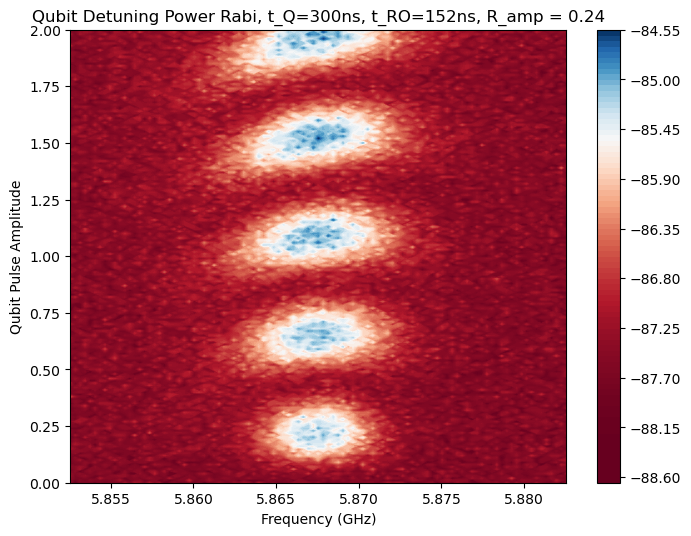

In [18]:
sig = Re + 1j*Im

power = 20*(np.log10(np.abs(sig)))#+10*np.log10(1000/50)#np.abs(sig)   #equation from wiki
power2=power/np.mean(power,axis=0)                             #norm lbl
power3=(scipy.ndimage.gaussian_filter(1/(power/np.mean(power,axis=0)),[1,5])) #gaussian filtered norm lbl
power4=power-np.mean(power,axis=0)                                    #sub lbl
power5=scipy.ndimage.gaussian_filter(power,[1,3])-np.mean(power,axis=0)#gaussian filtered sub lbl
power6=scipy.ndimage.gaussian_filter(power,[1,3]) #just gaussian filtered
phase = np.unwrap(np.arctan(Im/Re))

plt.figure(num=None, figsize=(8, 6), dpi=100)
plt.tight_layout()
#plt.plot(RO_lo+f_vec,power)
#wait_time = 0 

X, Y = np.meshgrid((Q1_lo+f_vec)/1e9, a_vec)
plt.contourf(X,Y, power.T,levels=100,norm=colors.PowerNorm(gamma=2.5),cmap='RdBu')
plt.xlabel('Frequency (GHz)')
# plt.title('Qubit PowSpec, t_Q={}ns, t_RO={}ns, wait={}ns, R_amp = {}, longw={}ns'.format(sat_Q1_len,readout_len,wait_time,b,5*sat_Q1_len))
plt.title('Qubit Detuning Power Rabi, t_Q={}ns, t_RO={}ns, R_amp = {}'.format(t*4,readout_len,b))
# #plt.xticks(X[0,0],X[0,-1])
plt.ylabel('Qubit Pulse Amplitude')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
# cbar.ax.set_ylabel('Normalized Signal Amplitude', rotation=270);

The pi pulse amplitude is 0.218.


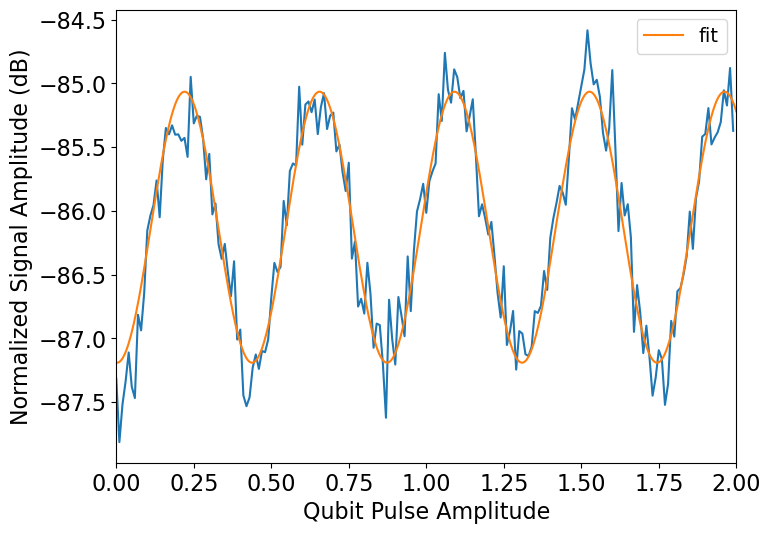

In [23]:
#Find frequency with max response 
#Fit a cosine to it 
#Determine pi pulse amplitude

i_f = 50
a_cut = -1

from scipy.optimize import curve_fit

def f_cos(a,A,drive_a,phi,C):
    return A*np.cos(2 * np.pi * a / drive_a + phi) + C # *np.exp(-t*2*np.pi/gamma)

popt, pcov = curve_fit(f_cos, a_vec[:a_cut], power[i_f,:a_cut],p0 = [1.5, .5, np.pi/4,-86])

a = np.linspace(0,a_vec[a_cut],500)
plt.figure(figsize = (8,6),dpi = 100)
plt.plot(a_vec[:a_cut],power[i_f,:a_cut])
plt.plot(a,f_cos(a,popt[0],popt[1],popt[2],popt[3]),label = 'fit')
plt.xlabel('Qubit Pulse Amplitude', fontsize = 16)
plt.ylabel('Normalized Signal Amplitude (dB)', fontsize = 16)
plt.xlim(0,a_vec[a_cut])
plt.xticks(fontsize = 16); plt.yticks(fontsize = 16);
plt.legend(fontsize = 14);

print(f'The pi pulse amplitude is {np.round(popt[1]/2,3)}.')

# Save this file and configuration file to measurement folder

In [ ]:
#save notebook
display(Javascript('IPython.notebook.save_checkpoint();'))

In [13]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [14]:
#define document paths
meas_path = os.path.join(os.getcwd(),M_name)

current_nb_path = os.path.join(os.getcwd(),nb_name)
save_nb_path = os.path.join(meas_path,nb_name)

current_config_path = os.path.join(os.getcwd(), 'Configuration_BMDevice.py')
save_config_path = os.path.join(meas_path, 'Configuration_BMDevice.py')

#copy to measurement folder 
copy2(current_nb_path,save_nb_path);
copy2(current_config_path,save_config_path);